# SLEAP Model Performance Analysis

This Python Notebook is used to analyze and compare the performances of SLEAP models. The metrics can also be used as further behavioral analysis.

The video orientation is the same as original R2 camera videos, which means the mouse first walks upwards and the restaurant is on the right side.

In [17]:
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import h5py
import os
from scipy.interpolate import interp1d


print("All necessary packages have been imported!")

All necessary packages have been imported!


The algorism accepts SLEAP analysis .h5 file as input.

The file can be **directly uploaded to workspace** or **read from Google Drive**.
Enter your h5 file path in Google Drive below.

In [18]:
drive.mount('/content/drive')

# Enter your Google Drive path here
!ls /content/drive/MyDrive/Wilbrecht_Lab/SLEAP_analysis
hdf5_path = '/content/drive/MyDrive/Wilbrecht_Lab/SLEAP_analysis/RRM030_camR4_Day139_Turns.avi.predictions.analysis.v003.1.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
initial_model_analysis.h5
RRM030_camR4_Day139_Turns.avi.predictions.analysis.v003.1.h5
RRM030_camR4_Day139_Turns.avi.predictions.analysis.woSeq.h5
RRM030_camR4_Day139_Turns.avi.predictions.analysis.wSeq.h5
v003_RRM030_camR4_Day139_Turns.avi.predictions.analysis.h5




---



# H5 to CSV

First let's **convert the h5 file into a csv file** for the convenience of preview and process.


### Note:

`h5_to_csv` function is modified from Data Team previous codes. There is a mistake in the original code:

```
coordinates = np.append(
                    coordinates, tracks_matrix[i - 1, node_index, 0, 0]
                )
```

`i - 1` will cause the first row of csv file to be the coordinates of the last frame. This problem has been addressed in the function below.

### Function

In [19]:
def h5_to_csv(hdf5_path, csv_file_path, frame_rate):
  '''convert h5 file into a csv file'''
  with h5py.File(hdf5_path, 'r') as f:
    dset_names = list(f.keys())
    occupancy_matrix = f["track_occupancy"][:]
    tracks_matrix = f["tracks"][:].transpose()
    nodes = [n.decode() for n in f["node_names"][:]]

  def coordinate(node_index, x_or_y):
      """Generate coordinate arrays for x or y based on node index."""
      coordinates = np.array([])
      for i in range(tracks_matrix.shape[0]):
          if x_or_y == "x":
              coordinates = np.append(coordinates, tracks_matrix[i, node_index, 0, 0])
          elif x_or_y == "y":
              coordinates = np.append(coordinates, tracks_matrix[i, node_index, 1, 0])
      return coordinates

  ihead = 0
  ineck = 1
  itorso = 2
  itailhead = 3

  head_x_coordinates = coordinate(ihead, "x")
  head_y_coordinates = coordinate(ihead, "y")
  neck_x_coordinates = coordinate(ineck, "x")
  neck_y_coordinates = coordinate(ineck, "y")
  torso_x_coordinates = coordinate(itorso, "x")
  torso_y_coordinates = coordinate(itorso, "y")
  tailhead_x_coordinates = coordinate(itailhead, "x")
  tailhead_y_coordinates = coordinate(itailhead, "y")

  df = pd.DataFrame(
    {
        "Head xCoordinates": head_x_coordinates,
        "Head yCoordinates": head_y_coordinates,
        "Neck xCoordinates": neck_x_coordinates,
        "Neck yCoordinates": neck_y_coordinates,
        "Torso xCoordinates": torso_x_coordinates,
        "Torso yCoordinates": torso_y_coordinates,
        "Tailhead xCoordinates": tailhead_x_coordinates,
        "Tailhead yCoordinates": tailhead_y_coordinates,
    }
  )
  csv_file = df.to_csv(csv_file_path, index=False)

In [20]:
h5_to_csv(hdf5_path,'analysis_raw.csv', 30)

# Pre-processing

## Data cleaning

First delete the rows with missing coordinates and save all data into analysis.csv.

In [21]:
def delete_missing_rows(matrix):
    """Delete rows with missing data from a 2D matrix."""
    rows_with_nan = matrix.isnull().any(axis=1)
    df_clean = matrix[~rows_with_nan]
    return df_clean

In [22]:
analysis_raw = pd.read_csv('analysis_raw.csv')
analysis = delete_missing_rows(analysis_raw)
total_frames = analysis.shape[0]
analysis.head()

,Head xCoordinates,Head yCoordinates,Neck xCoordinates,Neck yCoordinates,Torso xCoordinates,Torso yCoordinates,Tailhead xCoordinates,Tailhead yCoordinates
0,180.123032,68.789658,180.470062,63.874382,183.274551,51.805061,183.707581,39.434650
1,179.552734,76.695290,180.121140,71.846748,180.891785,59.735844,183.952682,44.746441
2,176.406723,84.146133,179.560028,79.331696,180.552444,67.168442,183.966461,52.267250
3,176.091034,91.928551,176.772614,84.648613,180.219284,72.236351,183.377914,59.602806
4,176.203125,99.390862,176.722900,92.173889,179.832291,79.667564,180.463181,64.580597


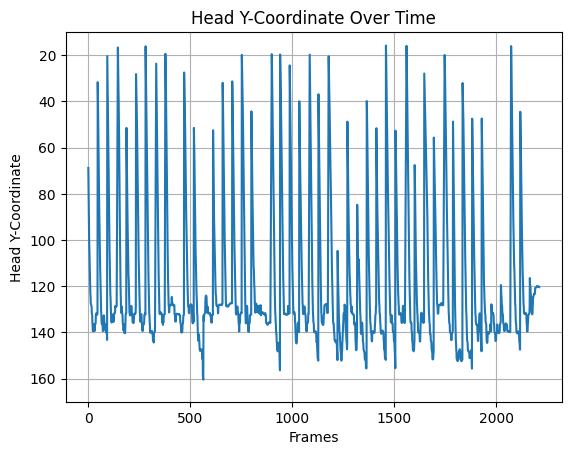

In [23]:
sns.lineplot(data=analysis, x=analysis.index, y='Head yCoordinates')
plt.title('Head Y-Coordinate Over Time')
plt.xlabel('Frames')
plt.ylabel('Head Y-Coordinate')
plt.ylim(170, 10)
#plt.xlim(0, 46)
plt.grid(True)
plt.show()



---



# Model Performance Analysis

### Edge length analysis

First, we calculate the length of all edges between adjacent body parts. We assume these lengths to be relativly stable, so the standard deviation can represent model stability.

In [24]:
# edge length standard deviation
frame_rate = 30  # frames per second

head_neck_len = np.sqrt(
    (analysis['Head xCoordinates'] - analysis['Neck xCoordinates'])**2 +
    (analysis['Head yCoordinates'] - analysis['Neck yCoordinates'])**2
)
neck_torso_len = np.sqrt(
    (analysis['Neck xCoordinates'] - analysis['Torso xCoordinates'])**2 +
    (analysis['Neck yCoordinates'] - analysis['Torso yCoordinates'])**2
)

torso_tailhead_len = np.sqrt(
    (analysis['Torso xCoordinates'] - analysis['Tailhead xCoordinates'])**2 +
    (analysis['Torso yCoordinates'] - analysis['Tailhead yCoordinates'])**2
)
head_neck_len_sd = np.std(head_neck_len)
neck_torso_len_sd = np.std(neck_torso_len)
torso_tailhead_len_sd = np.std(torso_tailhead_len)
print(
    f' head_neck_len_sd: {head_neck_len_sd}\n',
    f'neck_torso_len_sd: {neck_torso_len_sd}\n',
    f'torso_tailhead_len_sd: {torso_tailhead_len_sd}'
    )

 head_neck_len_sd: 1.1666585970542929
 neck_torso_len_sd: 1.9000694803490927
 torso_tailhead_len_sd: 1.9084369857624435


### Trunk orientation

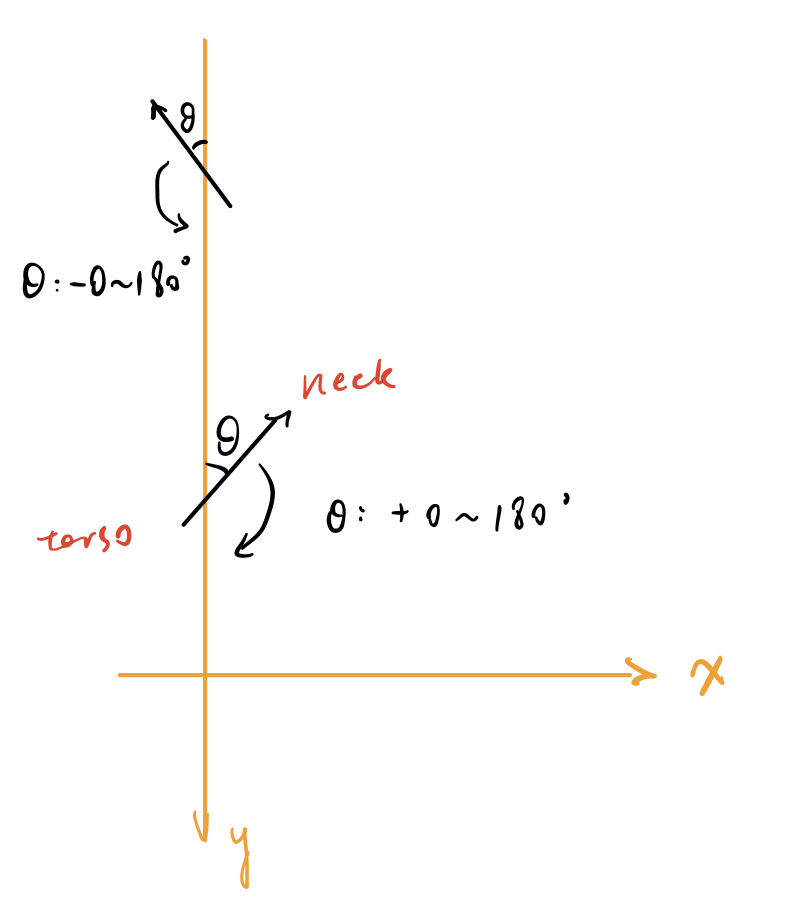

To calculate the vector's angle with y axis:
`np.degrees(np.arctan2(x2 - x1, -(y2 - y1)))`

All **orientations** are defined by *the angle between the vector and y axis* (left side is negative and right side is positive).

First, we should try to find the best representation of trunk orientation.
The options are: neck-torso direction, neck-tailhead direction, neck-torso-tailhead direction

### neck-torso orientation

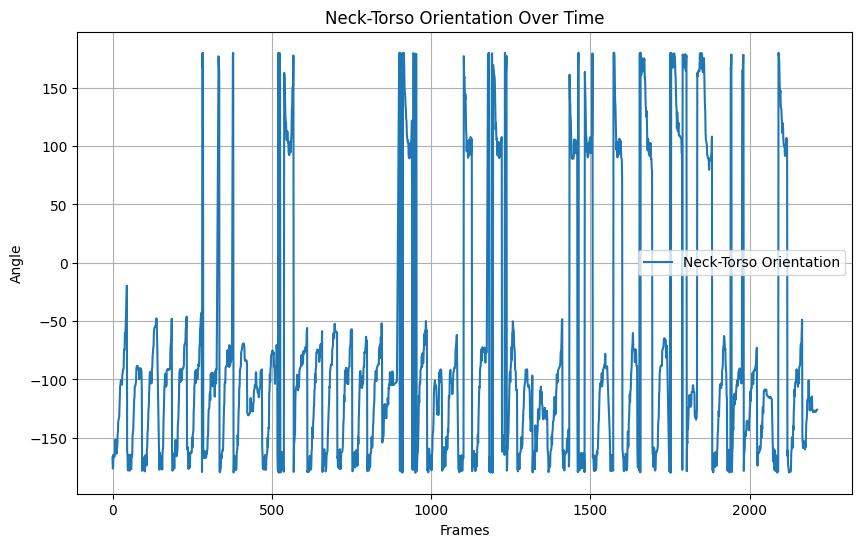

In [25]:
# Calculate the angle of the neck-torso edge relative to the berticle axis for each frame
neck_torso_orientation = np.degrees(np.arctan2(
    analysis['Neck xCoordinates'] - analysis['Torso xCoordinates'],
    -(analysis['Neck yCoordinates'] - analysis['Torso yCoordinates'])
))

# Plotting the direction of neck-torso edge over time
plt.figure(figsize=(10, 6))
plt.plot(neck_torso_orientation, label='Neck-Torso Orientation')
plt.xlabel('Frames')
plt.ylabel('Angle')
plt.title('Neck-Torso Orientation Over Time')
plt.legend()
plt.grid(True)
plt.show()

### neck-tailhead orientation

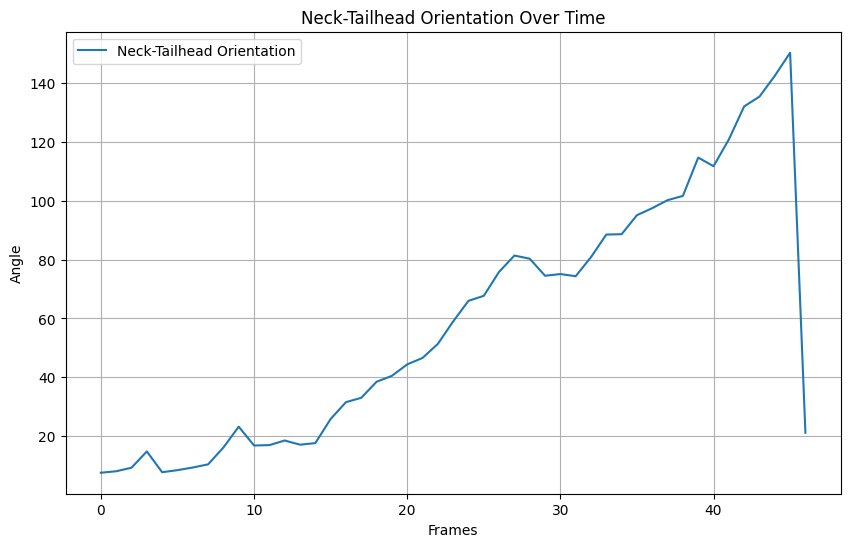

In [26]:
# Calculate the angle of the neck-tailhead edge relative to the verticle axis for each frame
neck_tailhead_orientation = np.degrees(np.arctan2(
    analysis['Tailhead xCoordinates'] - analysis['Neck xCoordinates'],
    analysis['Neck yCoordinates'] - analysis['Tailhead yCoordinates']
))

# Plotting the direction of neck-tailhead edge over time
plt.figure(figsize=(10, 6))
plt.plot(neck_tailhead_orientation[:47], label='Neck-Tailhead Orientation')
plt.xlabel('Frames')
plt.ylabel('Angle')
plt.title('Neck-Tailhead Orientation Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Straight walking head angle analysis

Then we extract all 'straight walking' movement for further analysis. We will use a threshold of head y coordinate as the criterion. The initial point should have a y coordinate less than 80 and the end point is 123. That means we extract all movement that head y-coordinate increase from an initial value (<80) to 123. Last 13 frames of all straight walking is extracted.

In [27]:
straight_walking = pd.DataFrame()
straight_walking_head_x = pd.DataFrame()

seg_num = 0
start_index = None
in_segment = False

for index, row in analysis.iterrows():
    if in_segment:
        if row['Head yCoordinates'] >= 123: # straight walk end (T-entry)
            seg_num+=1
            #segment_head_x = analysis.loc[index - 12:index, 'Head xCoordinates'].reset_index(drop=True)
            #straight_walking_head_x[f'Track {seg_num}'] = segment_head_x
            segment = analysis.loc[start_index:index]
            straight_walking = pd.concat([straight_walking, segment])
            in_segment = False
            start_index = None
    else:
        if row['Head yCoordinates'] < 80: # straight walk start
            start_index = index
            in_segment = True
if in_segment:
    segment = analysis.loc[start_index:]
    straight_walking = pd.concat([straight_walking, segment])

straight_walking.reset_index(drop=True, inplace=True)
straight_walking.head()
#print(f'Straight walking head x coordinates sd: {straight_walking_head_x.std(axis=0).mean()}')

,Head xCoordinates,Head yCoordinates,Neck xCoordinates,Neck yCoordinates,Torso xCoordinates,Torso yCoordinates,Tailhead xCoordinates,Tailhead yCoordinates
0,180.123032,68.789658,180.470062,63.874382,183.274551,51.805061,183.707581,39.434650
1,179.552734,76.695290,180.121140,71.846748,180.891785,59.735844,183.952682,44.746441
2,176.406723,84.146133,179.560028,79.331696,180.552444,67.168442,183.966461,52.267250
3,176.091034,91.928551,176.772614,84.648613,180.219284,72.236351,183.377914,59.602806
4,176.203125,99.390862,176.722900,92.173889,179.832291,79.667564,180.463181,64.580597


Head angle is defined by the angle between head-neck vector and the trunk orientation (right = positive; left = negative). During the straight walking movement, the head angle should be stable. Rapid changes in head orientation are mostly due to recognition jitters, so we can use the standard deviation of head angle to represent model preformance.

Head angle standard deviation = 92.36852570460215


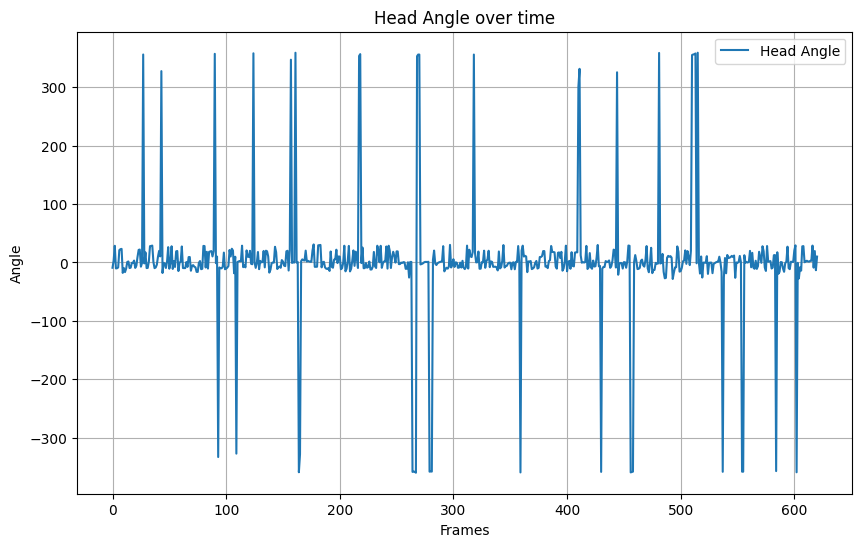

In [28]:
straight_trunk_orientation = np.degrees(np.arctan2(
    straight_walking['Neck xCoordinates'] - straight_walking['Torso xCoordinates'],
    -(straight_walking['Neck yCoordinates'] - straight_walking['Torso yCoordinates'])
))

straight_head_neck_orientation = np.degrees(np.arctan2(
    straight_walking['Head xCoordinates'] - straight_walking['Neck xCoordinates'],
    -(straight_walking['Head yCoordinates'] - straight_walking['Neck yCoordinates'])
))

straight_head_angle = straight_head_neck_orientation - straight_trunk_orientation

print(f'Head angle standard deviation = {np.std(straight_head_angle)}')

plt.figure(figsize=(10, 6))
plt.plot(straight_head_angle, label='Head Angle')
plt.xlabel('Frames')
plt.ylabel('Angle')
plt.title('Head Angle over time')
plt.legend()
plt.grid(True)
plt.show()


### 2 angles

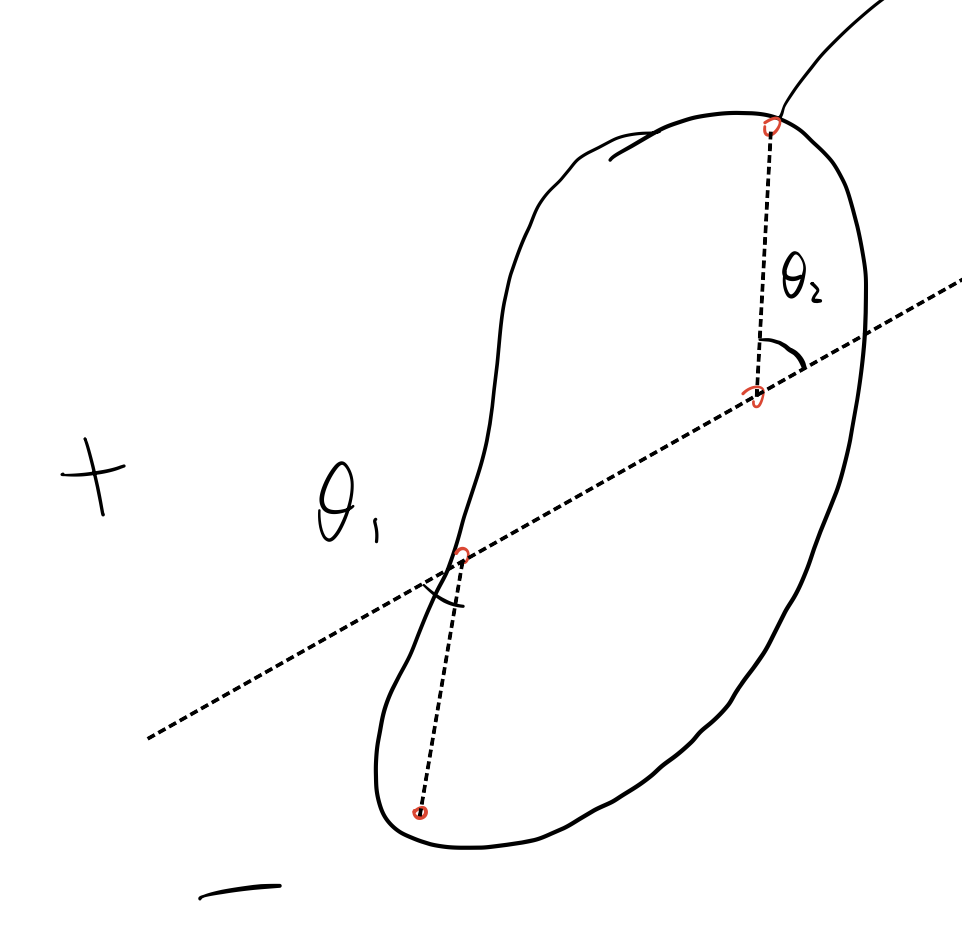
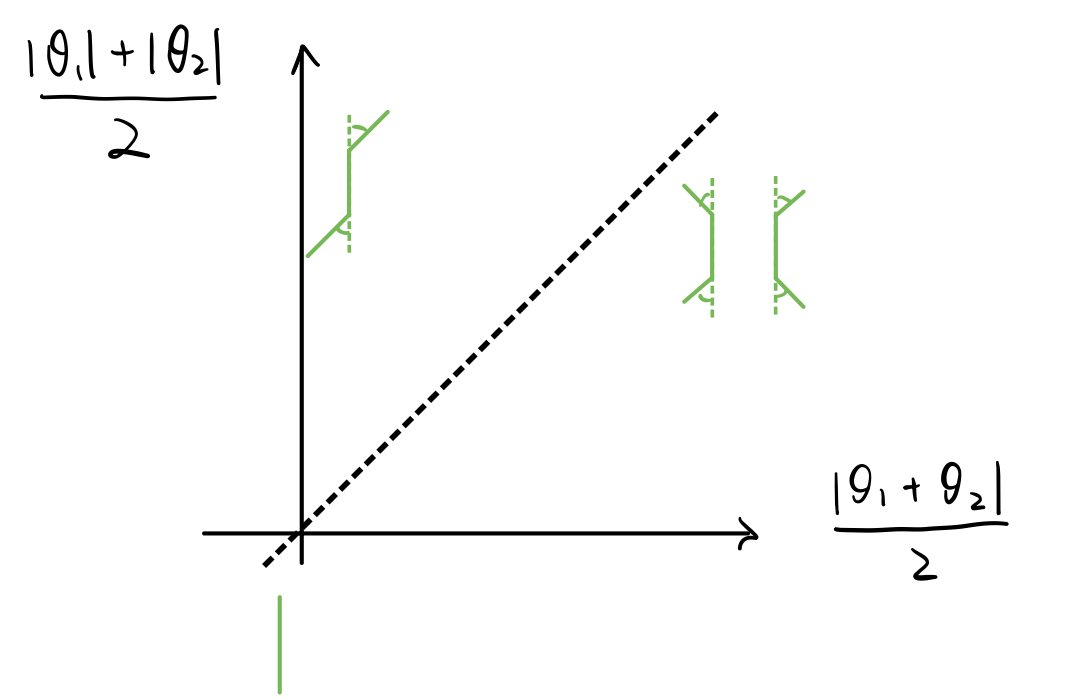

These two angles should be on the same side of the trunk orientation. The scenario shown in the figure where one is positive and one is negative should be due to the labeling mistakes.

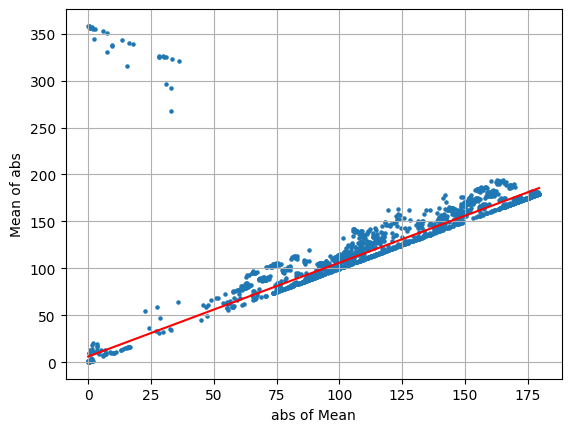

Proportion of twist-body frames is 0.410409949332105


In [29]:
trunk_orientation_head = np.degrees(np.arctan2(
    analysis['Neck xCoordinates'] - analysis['Torso xCoordinates'],
    -(analysis['Neck yCoordinates'] - analysis['Torso yCoordinates'])
))

head_neck_orientation = np.degrees(np.arctan2(
    analysis['Head xCoordinates'] - analysis['Neck xCoordinates'],
    -(analysis['Head yCoordinates'] - analysis['Neck yCoordinates'])
))

trunk_orientation_tail = np.degrees(np.arctan2(
    analysis['Torso xCoordinates'] - analysis['Neck xCoordinates'],
    -(analysis['Neck yCoordinates'] - analysis['Torso yCoordinates'])
))

torso_tailhead_orientation = np.degrees(np.arctan2(
    analysis['Torso xCoordinates'] - analysis['Tailhead xCoordinates'],
    -(analysis['Torso yCoordinates'] - analysis['Tailhead yCoordinates'])
))

theta_1 = head_neck_orientation - trunk_orientation_head
theta_2 = torso_tailhead_orientation - trunk_orientation_tail

x = abs(theta_1+theta_2) / 2
y = (abs(theta_1) + abs(theta_2)) / 2

plt.scatter(x, y, s=5)
plt.grid(True)
plt.xlabel('abs of Mean')
plt.ylabel('Mean of abs')

#manual decision boundary
slope = 1
intercept = 6

x_values = np.linspace(x.min(), x.max(), 100)

y_values = slope * x_values + intercept

plt.plot(x_values, y_values, 'r')

plt.show()

num_points_above = np.sum(y > slope * x + intercept)

print(f'Proportion of twist-body frames is {num_points_above / total_frames}')

Sum up the number of frames where two theta are heteoscedastic

In [30]:
mask_positive_theta1_negative_theta2 = (theta_1 > 0) & (theta_2 < 0)

mask_negative_theta1_positive_theta2 = (theta_1 < 0) & (theta_2 > 0)

mask_heteroscedastic = mask_positive_theta1_negative_theta2 | mask_negative_theta1_positive_theta2

number_of_heteroscedastic_frames = np.sum(mask_heteroscedastic)

print(f'The number of frames are {number_of_heteroscedastic_frames}')

The number of frames are 1344


# Metrics output

In [31]:
print(
    f'head_neck_len_sd: {head_neck_len_sd}\n'
    f'neck_torso_len_sd: {neck_torso_len_sd}\n'
    f'torso_tailhead_len_sd: {torso_tailhead_len_sd}\n'
    f'head angle standard deviation = {np.std(straight_head_angle)}\n'
    f'The number of frames are {number_of_heteroscedastic_frames}\n'
    f'Proportion of twist-body frames is {num_points_above / total_frames}\n'
    )

head_neck_len_sd: 1.1666585970542929
neck_torso_len_sd: 1.9000694803490927
torso_tailhead_len_sd: 1.9084369857624435
head angle standard deviation = 92.36852570460215
The number of frames are 1344
Proportion of twist-body frames is 0.410409949332105

